In [2]:
# !ls "/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768/checkpoints/"

In [1]:
# !rm "/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768/checkpoints/vqvae_motion.55000.pt"

In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [4]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [5]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset
from core.ofa.label_smoothed_cross_entropy import AdjustLabelSmoothedCrossEntropyCriterion
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs
from accelerate import DistributedType

In [ ]:
# !pip install accelerate

In [ ]:
import transformers

## Convert pt to pretrained bin

In [6]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/base_vqa_mix/ofa_vqa.32000.pt"


In [7]:
kwargs = DistributedDataParallelKwargs(find_unused_parameters = True)
accelerator = Accelerator(kwargs_handlers = [kwargs])

In [8]:
# fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/results/ofa_vqa.32000.pt"
pkg = torch.load(fine_tuned, map_location = 'cpu')

In [9]:
ofa_config = OFAConfig.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-base-vqa/')
vqa_model = OFAModelForVQA(ofa_config)

In [10]:
unwrapped_model = accelerator.unwrap_model(vqa_model)

In [11]:
unwrapped_model.load_state_dict(pkg['model'])

<All keys matched successfully>

In [12]:
unwrapped_model.save_pretrained('/coc/scratch/sanisetty3/DLM/ofa-base-vqa-mix/', save_function=accelerator.save)

##  Weight transfer to transformer model

In [79]:
model_b = OFAModelForVQA.from_pretrained("OFA-base/", use_cache=False)


In [81]:
base = torch.load("OFA-base/pytorch_model.bin")

In [172]:
base_vqa = torch.load("vqa_base_best.pt")["model"]
del base_vqa["encoder.version"]
del base_vqa["decoder.version"]

In [173]:
def change_key(self, old, new):
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v

In [174]:
 my_dic_keys = list(base_vqa.keys())

In [175]:
for i in my_dic_keys:
#     print(i)
    if "ffn_layernorm" in i and "encoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
    if "attn_ln" in i and "encoder" in i:
        new = str(i).replace("attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
        
    if "encoder_attn" in i and "decoder" in i:
        new = str(i).replace("encoder_attn","cross_attn")
        change_key(base_vqa , i , new)
        
    if "ffn_layernorm" in i and "decoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "cross_attn_ln" in i and "decoder" in i:
        new = str(i).replace("cross_attn_ln","cross_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "self_attn_ln" in i and "decoder" in i:
        new = str(i).replace("self_attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 

encoder.layers.0.attn_ln.weight
encoder.layers.0.attn_ln.bias
encoder.layers.0.ffn_layernorm.weight
encoder.layers.0.ffn_layernorm.bias
encoder.layers.1.attn_ln.weight
encoder.layers.1.attn_ln.bias
encoder.layers.1.ffn_layernorm.weight
encoder.layers.1.ffn_layernorm.bias
encoder.layers.2.attn_ln.weight
encoder.layers.2.attn_ln.bias
encoder.layers.2.ffn_layernorm.weight
encoder.layers.2.ffn_layernorm.bias
encoder.layers.3.attn_ln.weight
encoder.layers.3.attn_ln.bias
encoder.layers.3.ffn_layernorm.weight
encoder.layers.3.ffn_layernorm.bias
encoder.layers.4.attn_ln.weight
encoder.layers.4.attn_ln.bias
encoder.layers.4.ffn_layernorm.weight
encoder.layers.4.ffn_layernorm.bias
encoder.layers.5.attn_ln.weight
encoder.layers.5.attn_ln.bias
encoder.layers.5.ffn_layernorm.weight
encoder.layers.5.ffn_layernorm.bias


In [176]:
mis = []
for i in (base_vqa.keys()):
    
    if i in base.keys():
        continue
    else:
        print(i)
        mis.append(i)

len(mis)

0

In [177]:
torch.save(base_vqa , "OFA-base-vqa/pytorch_model.bin")

In [93]:
# model_p = OFAModelForVQA.from_pretrained("OFA-base-vqa/", use_cache=False)


## Test VQAv2

In [8]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-mix'
finetuned_b = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/'

tokenizer_p = OFATokenizer.from_pretrained(pretrained)


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [9]:
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()

In [10]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [12]:
ann_file = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root = '/srv/datasets/coco/'

ds = VqaDataset(
    ann_file=[ann_file],
    vqa_root=vqa_root,
)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [70]:
for batch in dl:
    break


In [74]:
# plt.imshow(batch["patch_images"][0].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5])

In [72]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

[' is the woman wearing glasses?', ' is the player right handed?', ' are the vehicles parked?', ' how many windows are present?', ' what color are the balls?', ' is the bathroom clean?', ' is this man silhouette altered by a hat?', ' what is the man wearing?']
['yes', 'yes', 'yes', '1', 'orange', 'no', 'no', 'casual attire']


In [73]:
gen = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
print(tokenizer_p.batch_decode(gen, skip_special_tokens=True))

[' yes', ' yes', ' yes', ' 1', ' brown', ' yes', ' no', ' pants']


In [75]:
gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
print(tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True))

['yes', 'yes', 'yes', '1', 'brown', 'yes', 'no', 'shirt and pants']


[' gray', ' 3', ' left', ' collie', ' no', ' no', ' yes', ' white']
question:  what color is the floor?
pred:  white
target:  white


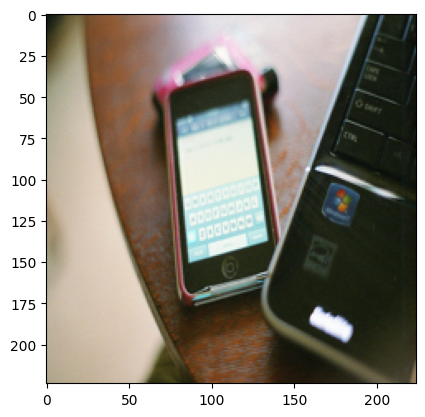

In [62]:
indx = 7
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]
plt.imshow(img)
gen = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
print(tokenizer_p.batch_decode(gen, skip_special_tokens=True))
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

['gray', '2', 'left', 'terrier', 'yes', 'no', 'yes', 'brown']
question:  what color is the floor?
pred:  brown
target:  white


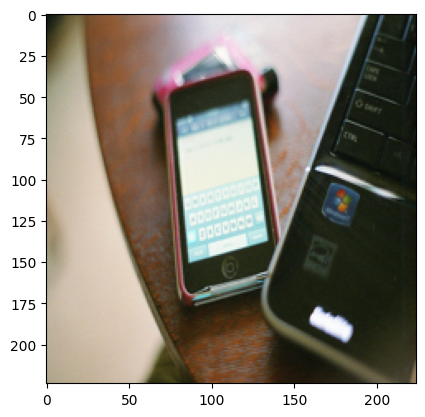

In [63]:
indx = 7
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]
plt.imshow(img)
gen = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
print(tokenizer_p.batch_decode(gen, skip_special_tokens=True))
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

## Test Stack

In [14]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
# finetuned = '/coc/scratch/sanisetty3/DLM/huggingface/ofa-vqa-base'

In [15]:
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-mix'

In [16]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [17]:
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


In [18]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [19]:
from core.datasets.vqa_gen_dataset import VQACollator, VqaDataset,VqaStackDataset,CLEVRVQADataset


In [16]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images"

In [21]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/images"


In [13]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/table_relation/train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/table_relation/images"


In [17]:
ds_stck = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
    patch_image_size = resolution,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(ds_stck, batch_size = 8, collate_fn=stack_data_collator ,num_workers = 0, shuffle = True)


In [15]:
ds_bowl = VqaStackDataset(
    ann_file='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json',
    vqa_root='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/images',
    patch_image_size = resolution,
)
bowl_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
bowl_dl = DataLoader(ds_bowl, batch_size = 8, collate_fn=bowl_data_collator ,num_workers = 0, shuffle = True)


In [20]:
ds = CLEVRVQADataset(split="valA" , patch_image_size = resolution,)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [28]:
leonardo_ds = LeonardoVQADataset(
        data_dir = '/srv/scratch/sanisetty3/DLM/sornet/data/leonardo/',
        split="valid",
        patch_image_size=480
    )

data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
leonardo_dl = DataLoader(leonardo_ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


12021

In [22]:
for batch in bowl_dl:
    break
    

In [23]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' what color is the block that is behind the gray cube?', ' are there any cyan bowls behind the brown block?', ' are there any blocks behind the purple block?', ' the block nearest to the purple bowl is what color?', ' what is the color of the bowl that is to the left of the gray bowl?', ' how many blocks are behind the purple bowl?', ' how many cubes are in front of the red cube?', ' what is the color of the bowl behind the gray cube?']


In [24]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['green', 'yes', 'yes', 'brown', 'blue', '4', '3', 'green']


### Pretrained

In [25]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['green', 'yes', 'yes', 'brown', 'blue', '4', '3', 'green']


In [26]:
gen = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)

RuntimeError: CUDA out of memory. Tried to allocate 310.00 MiB (GPU 0; 10.76 GiB total capacity; 2.68 GiB already allocated; 53.56 MiB free; 2.85 GiB reserved in total by PyTorch)

In [ ]:
tokenizer_p.batch_decode(gen, skip_special_tokens=True)

question:  are there any cyan bowls behind the brown block?


NameError: name 'gen' is not defined

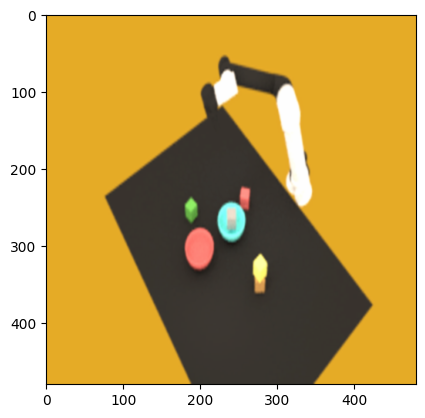

In [27]:
indx = 1
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

### Finetuned

In [55]:
# for batch in clevr_dl:
#     break

In [31]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['no', 'no', 'no', 'no', 'yes', 'gray', 'yes', 'red']


In [32]:
gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)

In [33]:
tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)

['no', 'no', 'no', 'no', 'yes', 'gray', 'no', 'red']

question:  are there any gray blocks on top of the brown block?
pred:  no
target:  no


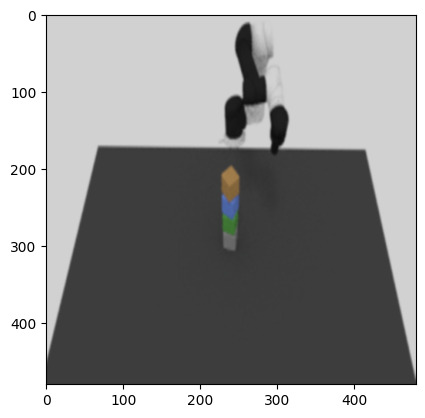

In [34]:
indx = 0
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

## Eval script

In [13]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset, CLEVRVQADataset,LeonardoVQADataset
import itertools

In [14]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
# pretrained ='/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-mix/'
finetuned_b = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/'

In [15]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda().eval()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda().eval()
model_b = OFAModelForVQA.from_pretrained(finetuned_b, use_cache=False).cuda().eval()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [ ]:
# from evaluate import load
# bertscore = load("bertscore")

In [43]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/images"


In [28]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images"

In [31]:
ann_file='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json'
vqa_root='/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/images'

In [26]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/table_relation/train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/table_relation/images"


In [44]:

stack_ds = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(stack_ds, batch_size = 10, collate_fn=stack_data_collator ,num_workers = 0, shuffle = False)


In [41]:
clevr_ds = CLEVRVQADataset(split="valB")
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
clevr_dl = DataLoader(clevr_ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


In [38]:
ann_file_coco = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root_coco = '/srv/datasets/coco/'

coco_ds = VqaDataset(
    ann_file=[ann_file_coco],
    vqa_root=vqa_root_coco,
)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
coco_dl = DataLoader(coco_ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [20]:
print(len(stack_ds) , len(clevr_ds), len(coco_ds))

12739 150000 443752


In [21]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [22]:
# leonardo_ds = LeonardoVQADataset(
#         data_dir = '/srv/scratch/sanisetty3/DLM/sornet/data/leonardo/',
#         split="valid",
#         patch_image_size=480
#     )

# data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
# leonardo_dl = DataLoader(leonardo_ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


In [23]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

## Stack

In [24]:
def get_accuracy(pred , targets):
    count = 0
    for i in range(len(pred)):
        for j in range(pred[0].shape[0]):
            try:
                trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])) == len(np.setdiff1d(targets[i][j],[0,1,2])))
                #int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))
                count+=trs
            except:
                continue          
    print(f"accuracy on {10*len(pred)} points" , count/(10*len(pred)))

In [25]:
def get_bert_score(pred,targets):

    decoded_preds_ = []
    for i in pred:
        decoded_preds_.append(tokenizer_p.batch_decode(i, skip_special_tokens=True))
    decoded_preds = [item for sublist in decoded_preds_ for item in sublist]

    decoded_trg_ = []
    for i in targets:
        decoded_trg_.append(tokenizer_p.batch_decode(i, skip_special_tokens=True))
    decoded_trg = [item for sublist in decoded_preds_ for item in sublist]

    results = bertscore.compute(predictions=decoded_preds, references=decoded_trg, lang="en")
    print(np.mean(results["precision"]))
    print(np.mean(results["recall"]))
    print(np.mean(results["f1"]))

In [26]:
ann_file

'/srv/scratch/sanisetty3/DLM/sornet/data/Test_set/questions.json'

In [46]:
from tqdm import tqdm

targets = []
pred = []
i = 0

# itr = cycle(stack_dl)
with torch.no_grad():

    for batch in tqdm(stack_dl):

        i+=1
        if i>200:
            break

        try:
    #         batch = next(itr)
            gen_fin = model_b.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
            pred.append(gen_fin)
            targets.append(batch["target"])
        except:
            continue
    
get_accuracy(pred,targets)
# get_bert_score(pred,targets)

  0%|                                                                                                                      | 0/1274 [00:00<?, ?it/s]/srv/share2/sanisetty3/miniconda3/envs/cliport/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
 16%|████████████████▉                                                                                           | 200/1274 [01:26<07:46,  2.30it/s]


accuracy on 2000 points 0.3935


In [29]:
'''
mix
test: 0.4245
stack:0.8785
bowl:0.55
valA:0.877
valB:1.0
coco:0.5523
table: 0.412
''' 

'\nmix\ntest: 0.42\nstack:0.833\nbowl:0.334\nvalA:0.877\nvalB:1.0\ncoco:0.6375\ntable: 0.412\n'

In [ ]:
'''
bowl
test: 0.383
stack:0.89
bowl:0.561
valA: 0.829
valB:0.8035
coco:0.27
table: 0.378

''' 

In [ ]:
detok = tokenizer_p.batch_decode(gen, skip_special_tokens=True)
scores = [ref_dict.get(str(result).strip(), 0) for ref_dict, result in zip(batch["ref_dict"], detok)]

score_sum += sum(scores) if scores is not None else 0
score_cnt += len(scores) if scores is not None else 0


In [58]:
for batch in coco_dl:
    break

In [39]:
from tqdm import tqdm

targets = []
pred = []
score_sum = 0
score_cnt = 0
i = 0

with torch.no_grad():
    for batch in tqdm(coco_dl):

        i+=1
        if i>200:
            break

        try:
    #         batch = next(itr)
            gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
            pred.append(gen_fin)
            targets.append(batch["target"])

            detok = tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)
            scores = [ref_dict.get(str(result).strip(), 0) for ref_dict, result in zip(batch["ref_dict"], detok)]
#             print(scores)
            score_sum += sum(scores) if scores is not None else 0
            score_cnt += len(scores) if scores is not None else 0

        except:
            continue
    
print(score_sum/score_cnt)
# get_bert_score(pred,targets)

  0%|                                                                                                                     | 0/44376 [00:00<?, ?it/s]/srv/share2/sanisetty3/miniconda3/envs/cliport/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  0%|▍                                                                                                       | 200/44376 [05:49<21:27:09,  1.75s/it]

0.5522333333333332


In [ ]:
f: 0.560

In [ ]:
p: 0.52

In [42]:
from tqdm import tqdm

targets = []
pred = []
i = 0
with torch.no_grad():

    for i in tqdm(range(200)):


        try:
            itr = cycle(clevr_dl)
            batch = next(itr)
            gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
            pred.append(gen_fin)
            targets.append(batch["target"])
        except:
            continue
        
get_accuracy(pred,targets)
# get_bert_score(pred,targets)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:46<00:00,  1.89it/s]


accuracy on 2000 points 0.885


In [106]:
from tqdm import tqdm

targets = []
pred = []
i = 0

# itr = cycle(stack_dl)

for batch in tqdm(stack_dl):

    try:
#         batch = next(itr)
        gen_fin = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
    
get_accuracy(pred,targets)
get_bert_score(pred,targets)

# count = 0
# for i in range(len(pred)):
# #     print(i)
#     for j in range(10):
# #         print(np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2]))
#         try:
#             #trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))
#             trs = int(sum(np.setdiff1d(targets[1][1],[0,1,2]) == np.setdiff1d(pred[1][1].detach().cpu().numpy(),[0,1,2])) == len(np.setdiff1d(targets[1][1],[0,1,2])))

#             count+=trs
#         except:
#             continue
            
            
# print(f"pretrained accuracy on {10*len(pred)} points" , count/(10*len(pred)))

  0%|                                                                                                         | 0/756 [00:00<?, ?it/s]/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [11:22<00:00,  1.11it/s]


accuracy on 7560 points 0.0
1.0000000654239631
1.0000000654239631
1.0000000654239631


In [21]:
from tqdm import tqdm

targets = []
pred = []
i = 0
for i in tqdm(range(1000)):
    
    
    try:
        itr = cycle(clevr_dl)
        batch = next(itr)
        gen_fin = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
        
get_accuracy(pred,targets)
get_bert_score(pred,targets)



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:50<00:00,  1.01s/it]


accuracy on 10000 points 0.0
1.000000073170662
1.000000073170662
1.000000073170662


## CLEVR

In [ ]:
from tqdm import tqdm

targets = []
pred = []
i = 0

# itr = cycle(stack_dl)
#         batch = next(itr)

for batch in stack_dl:

    try:
#         batch = next(itr)
        gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
    
    
    

## Custom image and question

In [58]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/'

In [50]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [51]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [59]:
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/images/*.png"
img_list = glob(vqa_root)

In [60]:
"What color is the block inside the gray bowl?",

('What color is the block inside the gray bowl?',)

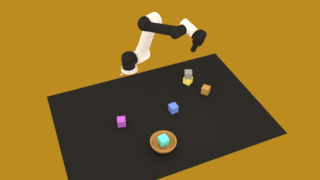

In [134]:
txt = "What color is the block on the left side of the table?"
inputs = tokenizer_p([txt], return_tensors="pt").input_ids
img = Image.open(img_list[23])
patch_img = patch_resize_transform(img).unsqueeze(0)
img

In [135]:
# "What color is the <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S>?",
# "What is the color of the <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S>?",
# "The <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S> is what color?"

# <R> includes closest farthest and six directions.

# "What number of <Z2> <C2> <M2> <S2>s are <R> the <Z> <C> <M> <S>?",
# "How many <Z2> <C2> <M2> <S2>s are <R> the <Z> <C> <M> <S>?"
# "Are there any <Z2> <C2> <M2> <S2>s <R> the <Z> <C> <M> <S>?"

### Pretrained

In [136]:
custom_gen = model_p.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)

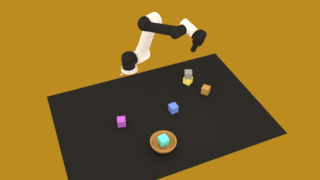

What color is the block on the left side of the table?
black


In [137]:
display(img)
print(txt)
print(tokenizer_p.batch_decode(custom_gen, skip_special_tokens=True)[0].strip())

### Fine tuned

In [138]:
custom_gen_fin = model_f.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)

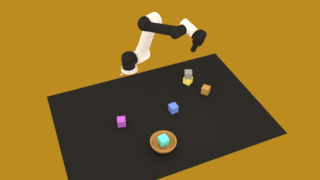

What color is the block on the left side of the table?
purple


In [139]:
display(img)
print(txt)
print(tokenizer_p.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip())

## Push to hub

In [153]:
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig

In [130]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [77]:
# fine_tuned ="/coc/scratch/sanisetty3/DLM/OFA-tiny-vqa-finetune/"
# pretrained ='/coc/scratch/sanisetty3/DLM/OFA-tiny/'

tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()
tokenizer_p = OFATokenizer.from_pretrained(finetuned)


In [134]:
# from huggingface_hub import notebook_login

# notebook_login()

In [133]:
# !transformers-cli repo create OFA-base-vqa-finetune

## Cleaning json

In [12]:
import re

In [ ]:
"What color is the <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S>?",
"What is the color of the <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S>?",
"The <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S> is what color?"

<R> includes closest farthest and six directions.

"What number of <Z2> <C2> <M2> <S2>s are <R> the <Z> <C> <M> <S>?",
"How many <Z2> <C2> <M2> <S2>s are <R> the <Z> <C> <M> <S>?"
"Are there any <Z2> <C2> <M2> <S2>s <R> the <Z> <C> <M> <S>?"

In [34]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json"

In [35]:
with open(ann_file) as f:
    ques = json.load(f)
len(ques["questions"])

11840

In [40]:

r1 = re.compile('.*inside.*cube.*')
r2 = re.compile('.*inside.*block.*')
r3 = re.compile('.*below.*bowl.*')

new_ques_dict = []
for item in ques["questions"]:
    quest = item["question"]
    if r1.match(quest) is not None:
        continue
    if r2.match(quest) is not None:
        continue
    if r3.match(quest) is not None:
        continue
        
    new_ques_dict.append(item)
    
    
new_questions = {"questions" : new_ques_dict}
json_object = json.dumps(new_questions, indent=4)
 
# Writing to sample.json
with open("/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json", "w") as outfile:
    outfile.write(json_object)

In [41]:
len(new_ques_dict)

11797

In [42]:
11840 - 11797

43

In [43]:
json_object = json.dumps(new_questions, indent=4)
 
# Writing to sample.json
with open("/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/bowl_train_questions.json", "w") as outfile:
    outfile.write(json_object)

## Official Eval method

In [ ]:
python3 ../../evaluate.py \
    ${data} \
    --path=${path} \
    --user-dir=${user_dir} \
    --task=vqa_gen \
    --batch-size=16 \
    --log-format=simple --log-interval=10 \
    --seed=7 \
    --gen-subset=${split} \
    --results-path=${result_path} \
    --fp16 \
    --ema-eval \
    --beam-search-vqa-eval \
    --beam=5 \
    --unnormalized \
    --temperature=1.0 \
    --num-workers=0 \
    --model-overrides="{\"data\":\"${data}\",\"bpe_dir\":\"${bpe_dir}\",\"selected_cols\":\"${selected_cols}\",\"ans2label_file\":\"${ans2label_file}\"}"
